In [1]:
# load the data from Johns Hopkins
import pandas
import numpy
import warnings
warnings.simplefilter("ignore")
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
confirmed = pandas.read_csv(url_confirmed)
deaths = pandas.read_csv(url_deaths)

In [2]:
# simplify that down to only confirmed cases and deaths
c = confirmed[confirmed["Country/Region"]=="US"].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1) \
  .transpose()
d = deaths[deaths["Country/Region"]=="US"].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1) \
  .transpose()
cd = pandas.DataFrame({"confirmed": c[c.columns[0]], "deaths": d[d.columns[0]]})

<AxesSubplot:>

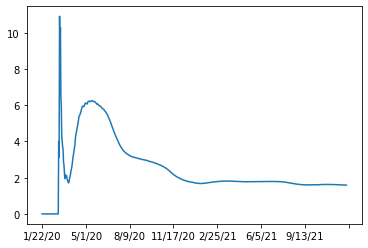

In [3]:
# plot the death rate over time (% chance of dying if you have a confirmed case)
cd["rate"] = 100 * cd["deaths"] / cd["confirmed"]
cd["rate"].plot()

In [4]:
# Let's get the average rate for the last 30 days
numpy.mean(list(cd["rate"])[-30:])

1.605926675033887

In [5]:
# Ok, so the death rate for confirmed cases has settled to 1.6% (1:60).
#
# According to this, only 1 in 4 covid infections are reported, so...
#   https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/burden.html
#
# The overall death rate for actual cases is therefore 1:240.
#
# NOTE 1: Since 20-30% of infections are completely asymptomatic, and quite a few more have only mild symptoms,
#         it is less than 50% likely that a person would actually know they had been infected.
# NOTE 2: If age and pre-existing health conditions were to be factored in this could be made more accurate

In [6]:
# Following note 2, let's look at this based on age.

# Here's census data to give us total population by age:
#   https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-detail.html#par_textimage_1537638156
pop_by_age = pandas.read_csv("us_pop_by_age.csv")

In [7]:
# And here is some recent data for Covid and total deaths in 2021 (snapshot taken on Dec 17th)
#   https://www.cdc.gov/nchs/nvss/vsrr/covid_weekly/index.htm#SexAndAge
#
# NOTE: the 'covid deaths' value here is 'any death involving Covid', so if someone was hit by a truck and happened
#       to test positive for Covid, that death was counted.  Therefore it is a little high, but I didn't see
#       another column that attempted to factor these out.
deaths_by_age_range = [
    [0, 457, 30812],
    [18, 3299, 60511],
    [30, 9858, 91990],
    [40, 22915, 137428],
    [50, 90597, 542044],
    [65, 99007, 646965],
    [75, 99367, 744250],
    [85, 86644, 848817]
]
# columns in 'deaths':
#   age0, age1   = age range
#   covid_deaths = deaths attributed to covid (see note above)
#   total_deaths = deaths by any cause
#   population   = total number of people within the age range
for n, (age0, covid_deaths, total_deaths) in enumerate(deaths_by_age_range):
    age1 = deaths_by_age_range[n+1][0] if n+1 < len(deaths_by_age_range) else 101
    pop_in_range = pop_by_age[pop_by_age.age >= age0][pop_by_age.age < age1]["count"].sum()
    deaths_by_age_range[n] += [age1, pop_in_range]
deaths = pandas.DataFrame(data=deaths_by_age_range, columns=["age0", "covid_deaths", "total_deaths", "age1", "population"])

In [8]:
# First of all, what do those risk-of-death levels look like for each age?
covid_as_cause = deaths[["age0", "age1"]]
covid_as_cause["covid_pct"] = 100 * deaths["covid_deaths"] / deaths["total_deaths"]
covid_as_cause

,age0,age1,covid_pct
0,0,18,1.483188
1,18,30,5.451901
2,30,40,10.716382
3,40,50,16.674186
4,50,65,16.713957
5,65,75,15.303301
6,75,85,13.351293
7,85,101,10.207618


In [9]:
# So in general, however likely or unlikely it may be, if someone aged 0-18 died, it was a 1.5% chance that they died
# of Covid, and if someone 50-65 died it was a 17% chance they died of Covid.

# But those populations are of very different sizes.  Let's see what the overall death rate was, that is, what are
# the odds that a person in each population range died of Covid.
death_rate = deaths[["age0", "age1"]]
death_rate["pct_covid_death"] = 100 * deaths["covid_deaths"] / deaths["population"]
death_rate["odds_covid_death"] = 100 / death_rate["pct_covid_death"]
death_rate["pct_any_death"] = 100 * deaths["total_deaths"] / deaths["population"]
death_rate["odds_any_death"] = 100 / death_rate["pct_any_death"]
death_rate

,age0,age1,pct_covid_death,odds_covid_death,pct_any_death,odds_any_death
0,0,18,0.000626,159823.085339,0.042186,2370.477411
1,18,30,0.006140,16286.214610,0.112624,887.908347
2,30,40,0.022319,4480.505782,0.208269,480.148125
3,40,50,0.056834,1759.518830,0.340849,293.385438
4,50,65,0.143975,694.567017,0.861403,116.089631
5,65,75,0.314473,317.991990,2.054938,48.663271
6,75,85,0.622215,160.716053,4.660338,21.457671
7,85,101,1.311802,76.230991,12.851210,7.781369


In [10]:
# So the odds of someone age 0-18 dying of Covid in 2021 were 1:160000 and the odds of someone aged 50-65 were 1:650
# The odds of dying, in general, in those age ranges are 1:2400 and 1:100, respectively
#
# That helps understand the statistic given a few cells earlier:
#   "If someone aged 0-18 died, it was a 1.5% chance that they died of Covid,
#   and if someone 50-65 died it was a 17% chance they died of Covid."
#
# So for the 0-18 age range it was a 1.5% chance of the cause of death being Covid, but the overall chance of death
# was only 1:2400.  So the 1.5% is misleading.  Let's put it another way.
#
# Dear 0-18 year old, it has been determined that this year you have a 1 in 2400 chance of dying.  If you happen
# to die, the chances of the cause being Covid are about 1 in 60.
#
# But for a 50-65 year old it should be phrased differently.
#
# Hello 50-65 year old, Death here.  I have made a grid of 25 by 25 squares.  6 of those squares are colored red,
# and one of those red squares is labeled "Covid".  At some time this year I will throw a dart at this grid
# (and I never miss), and you know what happens if it lands on a red square...  Mwahahaha!
#
# In the first case, Covid is really not a discernible component of a rational fear.  In the second case, Covid is
# still not a huge factor, but it is much more noticeable, large enough to be annoying.  Who wants another red square
# added to their matrix of death?
#
# The comparable grid for the 0-18 year olds would be 400x400, with 60 red squares, one of which is labeled Covid.

In [11]:
# One could certainly add pre-existing health conditions to further elaborate the nuances.
# Here is one source:
#   https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/preexistingconditionsofpeoplewhodiedduetocovid19englandandwales
# According to that, roughly 6 out of 7 Covid deaths in England involved pre-existing conditions.
# This site indicates conditions that increase the risk, but they are not quantified:
#   https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-with-medical-conditions.html
#
# That 1:7 number is drawn from only one article and so should be taken with several grains of salt.  But suffice it
# to say that there is some number that is reflective of this statistic.  Whatever that number may actually be,
# the 'story' that Death tells would vary even more than stated above between a young, healthy person and an old,
# feeble person.
#
# As a final note, no statistic is so small that it couldn't happen.  Regardless of what number squares are colored
# red, we know that some of them are red and that Death is regularly throwing darts.  And it is very important to
# remember that statistics are a mirage, a cloud of rationality attempting to shape itself to observed events.  Each
# actual event that occurs always has an 'effective probability' of 100% because it absolutely did, in fact, happen.


In [12]:
# What are the chances of getting Covid, though?  And of getting it but not knowing?

# First of all the overall average.
total_pop = pop_by_age["count"].sum()
total_confirmed = list(c[c.columns[0]])[-1]
print(total_confirmed/1e6, "M confirmed / ", total_pop/1e6, "M people = ", 100 * total_confirmed/total_pop, "%")

50.706733 M confirmed /  328.239523 M people =  15.448088803126856 %


In [13]:
# That's odd.  If the actual cases are 4X higher than the confirmed then 64% of the population has had it, and we 
# are nearing saturation.

# (This doesn't factor in double counting (some people have had it more than once), but that doesn't seem like a
# super frequent phenomenon.)